In [5]:
import pandas as pd
import numpy as np
import re
import datetime
import math
from sklearn.cluster import KMeans
import geopandas as gpd
import h3 # h3 bins from uber
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
def create_crash_df(train_file = '../Inputs/Train.csv'):  
    crash_data_df = pd.read_csv(train_file, parse_dates=['datetime'])
    return crash_data_df

def create_temporal_features(df):
    dict_windows = {1: "00-03", 2: "03-06", 3: "06-09", 4: "09-12", 5: "12-15", 6: "15-18", 7: "18-21", 8: "21-24"}
    dict_months = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
               7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}
    
    df["time_window"] = df["datetime"].apply(lambda x: math.floor(x.hour / 3) + 1)
    df["time_window_str"] = df["time_window"].apply(lambda x: dict_windows.get(x))
    df["day"] = df["datetime"].apply(lambda x: x.day)
    df["month"] = df["datetime"].apply(lambda x: dict_months.get(x.month))
    df["year"] = df["datetime"].apply(lambda x: x.year)
    df["weekday"] = df["datetime"].apply(lambda x: x.weekday())
    return df

def assign_hex_bin(df,lat_column="latitude",lon_column="longitude"):
    df["h3_zone_5"] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], 5),axis=1)
    df["h3_zone_6"] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], 6),axis=1)
    df["h3_zone_7"] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], 7),axis=1)
    return df


In [69]:
def create_submission_df(crash_data_df, date_start='2019-07-01', date_end='2020-01-01'):
    '''Takes crash data and creates a data frame in the format needed for submission'''
    
    #calculate centroid for ambulance placement
    #lat_centroid = list(crash_data_df.latitude.quantile(q=[1/7,2/7,3/7,4/7,5/7,6/7]))
    #lon_centroid = list(crash_data_df.longitude.quantile(q=[1/7,2/7,3/7,4/7,5/7,6/7]))
    
    # create 6 points on a grid
    #lat_centroid = list(crash_data_df.latitude.quantile(q=[1/4,2/4,3/4]))
    #lon_centroid = list(crash_data_df.longitude.quantile(q=[1/3,2/3]))
    #centroids = [(lat,lon) for lat in lat_centroid for lon in lon_centroid]
    
    # star of david grid
    #lat_centroid = list(crash_data_df.latitude.quantile(q=[1/5,2/5,3/5,4/5]))
    #lon_centroid = list(crash_data_df.longitude.quantile(q=[1/4,2/4,3/4]))
    #centroids=[(lat_centroid[1],lon_centroid[0]),(lat_centroid[2],lon_centroid[0]),
    #           (lat_centroid[0],lon_centroid[1]),(lat_centroid[3],lon_centroid[1]),
    #           (lat_centroid[1],lon_centroid[2]),(lat_centroid[2],lon_centroid[2])]
    
    # Create centroids via k-means
    kmeans = KMeans(n_clusters=6, verbose=0, tol=1e-3, max_iter=100, n_init=20, copy_x= True)
    kmeans.fit(crash_data_df[['latitude','longitude']])
    centroids = kmeans.cluster_centers_
    
    # Create Date range covering submission period set
    dates = pd.date_range(date_start, date_end, freq='3h')
        
    # Create submission dataframe
    submission_df = pd.DataFrame({'date':dates})
    #submission_df['weekday'] = submission_df['date'].apply
    for ambulance in range(6):
        # Place an ambulance in the center of the city:
        submission_df['A'+str(ambulance)+'_Latitude'] = centroids[ambulance][0]
        submission_df['A'+str(ambulance)+'_Longitude'] = centroids[ambulance][1]
    #print(f'Score={score()}')
    return submission_df, centroids

In [27]:
def create_submission_csv(submission_df, model_name='baseline', path='../Outputs/'):
    '''Takes dataframe in submission format and outputs a csv file with matching name'''
    current_time = datetime.datetime.now()
    filename = f'{current_time.year}{current_time.month}{current_time.day}_{model_name}.csv'
    submission_df.to_csv(path+filename,index=False)

In [25]:
# Load raw crash data from csv
crash_data_df = pd.read_csv('../Inputs/Train.csv', parse_dates=['datetime'])

In [42]:
def score(submission_df=submission_df, crash_data_df=crash_data_df, test_start_date='2018-01-01'):
    test_df = crash_data_df.loc[crash_data_df.datetime > test_start_date]
    display(test_df.head())
    total_distance = 0
    for date, c_lat, c_lon in test_df[['datetime', 'latitude', 'longitude']].values:
        row = test_df.loc[submission_df.date < date].tail(1)
        dists = []
        for a in range(6):
            dist = ((c_lat - row[f'A{a}_Latitude'].values[0])**2+(c_lon - row[f'A{a}_Longitude'].values[0])**2)**0.5 
            dists.append(dist)
        total_distance += min(dists)
    return total_distance

In [70]:
# call function to create submission df and csv output
submission_df, centroids = create_submission_df(crash_data_df)
centroids
#create_submission_csv(submission_df,'star_grid')

array([[-1.19983123, 36.92128143],
       [-2.26993277, 37.38589229],
       [-1.23330826, 36.72098959],
       [-1.29836033, 36.84037964],
       [-1.44752882, 37.0401509 ],
       [-0.98030485, 37.08421802]])

In [50]:
# View contents of submission
submission_df.head()

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude
0,2019-07-01 00:00:00,-1.447529,37.040151,-2.269933,37.385892,-1.233308,36.72099,-0.97529,37.087235,-1.19904,36.922061,-1.298335,36.840378
1,2019-07-01 03:00:00,-1.447529,37.040151,-2.269933,37.385892,-1.233308,36.72099,-0.97529,37.087235,-1.19904,36.922061,-1.298335,36.840378
2,2019-07-01 06:00:00,-1.447529,37.040151,-2.269933,37.385892,-1.233308,36.72099,-0.97529,37.087235,-1.19904,36.922061,-1.298335,36.840378
3,2019-07-01 09:00:00,-1.447529,37.040151,-2.269933,37.385892,-1.233308,36.72099,-0.97529,37.087235,-1.19904,36.922061,-1.298335,36.840378
4,2019-07-01 12:00:00,-1.447529,37.040151,-2.269933,37.385892,-1.233308,36.72099,-0.97529,37.087235,-1.19904,36.922061,-1.298335,36.840378


In [27]:
# for simple qunatile grid we want to know which dimension is more widely spread and make that the dim with 3  We will use wider dimension to have 3 points and the other 2
display(crash_data_df.describe().round(4))
print(f'latitutude range is {crash_data_df.latitude.max()-crash_data_df.latitude.min()}')
print(f'longitude range is {crash_data_df.longitude.max()-crash_data_df.longitude.min()}')

,uid,latitude,longitude
count,6318.0000,6318.0000,6318.0000
mean,3159.5000,-1.2703,36.8555
std,1823.9938,0.1252,0.1129
min,1.0000,-3.0500,36.3322
25%,1580.2500,-1.3166,36.8020
50%,3159.5000,-1.2717,36.8446
75%,4738.7500,-1.2337,36.8956
max,6318.0000,-0.5654,37.8795


latitutude range is 2.4845976883566063
longitude range is 1.5472883973901048


In [11]:
# functions for saving post submission details to a dataframe
def get_submission_details(copypaste):
    split_input = re.split("\s", copypaste)
    id_str = split_input[0]
    score_float = split_input[-1]
    file_name = filename = re.findall('\w*.csv\w*', copypaste)[-1]
    comment_str = ''
    submitted_datetime = ''
    submission_row = [id_str, file_name, score_float, submitted_datetime, comment_str]
    return submission_row
def submission_dataframe(rows,columns=['ID', 'FILE', 'SCORE', 'SUBMITTED', 'COMMENT']):
    return pd.DataFrame(data=[rows], columns = columns)

def create_dataframe(copypaste):
    return submission_dataframe(get_submission_details(copypaste))

# the below needs work
def add_to_submission_dataframe(df, rows, columns=['ID', 'FILE', 'SCORE', 'SUBMITTED', 'COMMENT']):
    return df.append(zip([columns,rows]), ignore_index=True)

def update_dataframe(df, copypaste):
    rows = get_submission_details(copypaste)
    return add_to_submission_dataframe(df, rows)

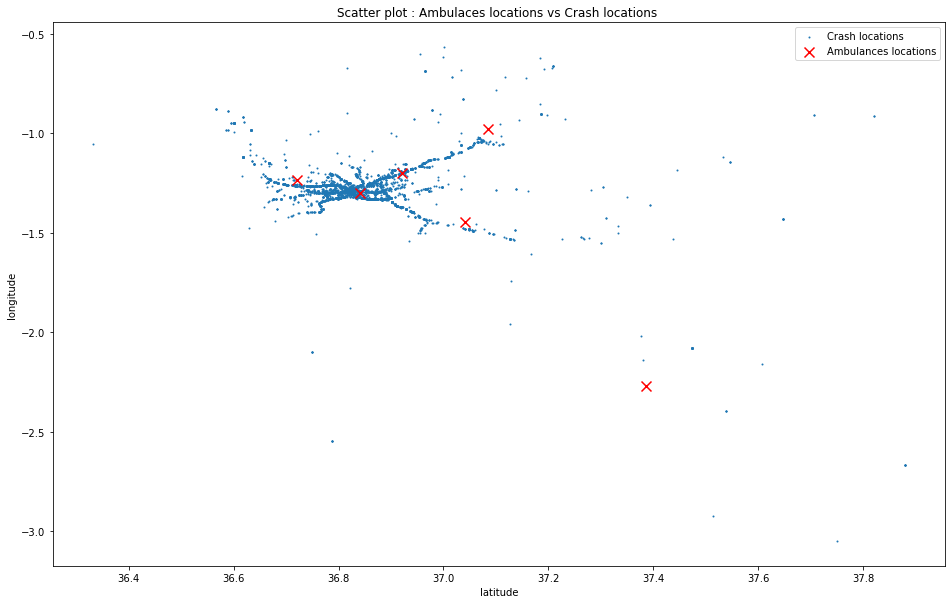

In [71]:
def plot_centroids(crash_data_df, centroids=centroids):
    fig, axs = plt.subplots(figsize=(16, 10))

    plt.scatter(x = crash_data_df['longitude'], y=crash_data_df['latitude'], s=1, label='Crash locations' )
    plt.scatter(x = centroids[:,1], y=centroids[:,0], marker="x",
                color='r',label='Ambulances locations',s=100)
    axs.set_title('Scatter plot : Ambulaces locations vs Crash locations ')
    plt.xlabel("latitude")
    plt.ylabel("longitude")
    plt.legend()
    plt.show()

plot_centroids(crash_data_df,centroids)

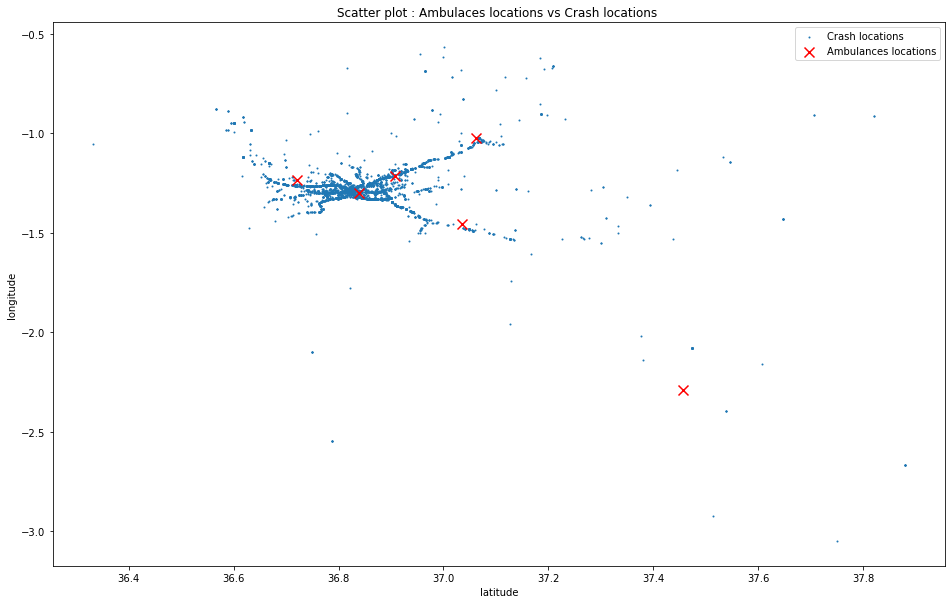

In [57]:
def plot_ambulances(crash_data_df):
       # Create centroids via k-means
    kmeans = KMeans(n_clusters=6, verbose=0, tol=1e-3, max_iter=100, n_init=20, copy_x= True, random_state=1)
    kmeans.fit(crash_data_df[['latitude','longitude']])
    centroids = kmeans.cluster_centers_
    fig, axs = plt.subplots(figsize=(16, 10))

    plt.scatter(x = crash_data_df['longitude'], y=crash_data_df['latitude'], s=1, label='Crash locations' )
    plt.scatter(x = centroids[:,1], y=centroids[:,0], marker="x",
                color='r',label='Ambulances locations',s=100)
    axs.set_title('Scatter plot : Ambulaces locations vs Crash locations ')
    plt.xlabel("latitude")
    plt.ylabel("longitude")
    plt.legend()
    plt.show()

plot_ambulances(crash_data_df)

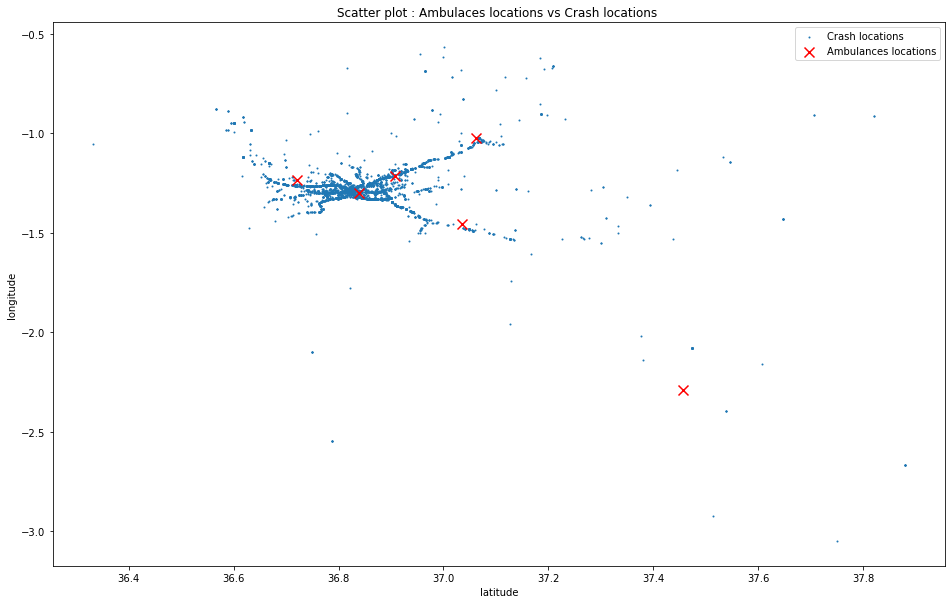